## Captcha Image Processing

- The methodology of this system is referenced from 
[here](https://medium.com/@ageitgey/how-to-break-a-captcha-system-in-15-minutes-with-machine-learning-dbebb035a710). Additional image processing and image augmentation have been done.

- The captcha system employed in this website of interest could not be cracked using [Python Tesseract](https://pypi.org/project/pytesseract/) . This is mainly because of the noise in the images. It has the same colour as the captcha letters themselves and hence it is hard to be removed.

- Since the captcha images from this website rotate in different angles at different times of the month, individual captcha letters are heavily augmented to accomodate this so that the effort and time to manually label the captchas could be reduced.

In [30]:
from PIL import Image
import numpy as np
import sys
import matplotlib.pyplot as plt
import imutils
from imutils import paths
import cv2
import os
import os.path
import glob
import pickle
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout
from kerastuner.tuners import RandomSearch
import kerastuner

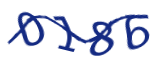

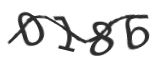

In [31]:
# working directory
wd = os.getcwd()
image = Image.open(wd + "\\images\\labeled\\labeled_training\\left_labeled_1\\0186.jpg")
display(image)
image = image.convert("L") # Grayscale conversion
display(image)


### cut images into individual letters

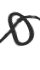

(40, 70)


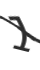

(40, 70)


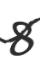

(40, 70)


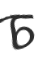

(40, 70)


In [3]:
cropped_image1 = image.crop((10, 0, 50, 70))
display(cropped_image1)
print(cropped_image1.size)

cropped_image2 = image.crop((45, 0, 85, 70))
display(cropped_image2)
print(cropped_image2.size)

cropped_image3 = image.crop((80, 0, 120, 70))
display(cropped_image3)
print(cropped_image3.size)

cropped_image4 = image.crop((115, 0, 150, 70))
display(cropped_image4)
print(cropped_image3.size)

### remove entirely white pixel rows

In [4]:
np_im = np.array(cropped_image4) # concert to np array
non_white_rows = np.where(np.all(np_im==255, axis=1)==False)
first_element = non_white_rows[0][0] -2 # the first row that is not white + 2 white rows    
last_element = non_white_rows[0][len(non_white_rows[0])-1] + 2  # the last row that is not white + 2 white rows
non_white = np_im[first_element:last_element, :]

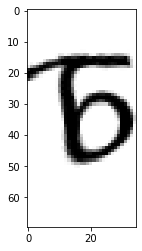

(70, 35)

In [5]:
plt.imshow(np_im, cmap="gray")
plt.show()
np_im.shape

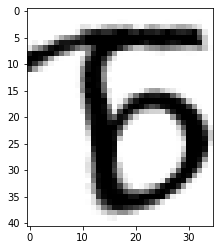

(41, 35)

In [6]:
plt.imshow(non_white, cmap="gray")
plt.show()
non_white.shape


- The above two images show the before and after of removal of white rows.

### helper function to resize

In [32]:
# helper function to resize image array

def resize_to_fit(image, width, height):
    """
    A helper function to resize an image to fit within a given size
    :param image: image to resize
    :param width: desired width in pixels
    :param height: desired height in pixels
    :return: the resized image
    """

    # grab the dimensions of the image, then initialize
    # the padding values
    (h, w) = image.shape[:2]

    # if the width is greater than the height then resize along
    # the width
    if w > h:
        image = imutils.resize(image, width=width)

    # otherwise, the height is greater than the width so resize
    # along the height
    else:
        image = imutils.resize(image, height=height)

    # determine the padding values for the width and height to obtain the target dimensions
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((height - image.shape[0]) / 2.0)

    # pad the image then apply one more resizing to handle any rounding issues
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))

    # return the pre-processed image
    return image

### combine 1.1, 1.2, 1.3 to a function

In [33]:
def img_process(np_im, size_x, size_y):
    
    non_white_rows = np.where(np.all(np_im==255, axis=1)==False)
    first_element = non_white_rows[0][0] -2 # the first row that is not white + 2 white rows    
    last_element = non_white_rows[0][len(non_white_rows[0])-1] + 2  # the last row that is not white + 2 white rows
    non_white = np_im[first_element:last_element, :]    
    resize_non_white = resize_to_fit(non_white, size_x, size_y) #resize
    
    return resize_non_white

### save each individual letter image to a new folder

- This is an example of image processing of an image folder. The labeled captcha images will be processed into individual letters and saved in individual letter folders.

In [25]:
CAPTCHA_IMAGE_FOLDER = "\\images\\labeled\\labeled_left\\left_labeled_1"
OUTPUT_FOLDER = "\\images\\extracted_letter_images"

# Get a list of all the captcha images we need to process
captcha_image_files = glob.glob(wd + CAPTCHA_IMAGE_FOLDER + "\\*")

In [21]:
# loop over the image paths
for (i, captcha_image_file) in enumerate(captcha_image_files):
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))

    # Since the filename contains the captcha text (i.e. "0186.jpg" has the text "0186"),
    # grab the base filename as the text
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]

    # Load the image and convert it to grayscale
    image = Image.open(captcha_image_file).convert("L") # Grayscale conversion  

    cropped_image1 = np.array(image.crop((10, 0, 50, 70)))
    cropped_image2 = np.array(image.crop((45, 0, 85, 70)))
    cropped_image3 = np.array(image.crop((80, 0, 120, 70)))
    cropped_image4 = np.array(image.crop((120, 0, 160, 70)))

    cropped_image = [cropped_image1, cropped_image2, cropped_image3, cropped_image4]
      
    # Save out each letter as a single image
    for ind_img, letter_text in zip(cropped_image, captcha_correct_text):
        
        img_array = img_process(ind_img, 40, 40)
        img = Image.fromarray(img_array) #convert np.array back to image
       
        # Get the folder to save the image in
        save_path = os.path.join(wd + OUTPUT_FOLDER, letter_text)

        # if the output directory does not exist, create it
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        
        try:
            max_fileno = max([int(f[:f.index('.')]) for f in os.listdir(save_path)])
        except ValueError:
            max_fileno = 0
        
        p = os.path.join(save_path, "{}.png".format(str(max_fileno + 1).zfill(6)))
        img.save(p)

[INFO] processing image 1/1928
[INFO] processing image 2/1928
[INFO] processing image 3/1928
[INFO] processing image 4/1928
[INFO] processing image 5/1928
[INFO] processing image 6/1928
[INFO] processing image 7/1928
[INFO] processing image 8/1928
[INFO] processing image 9/1928
[INFO] processing image 10/1928
[INFO] processing image 11/1928
[INFO] processing image 12/1928
[INFO] processing image 13/1928
[INFO] processing image 14/1928
[INFO] processing image 15/1928
[INFO] processing image 16/1928
[INFO] processing image 17/1928
[INFO] processing image 18/1928
[INFO] processing image 19/1928
[INFO] processing image 20/1928
[INFO] processing image 21/1928
[INFO] processing image 22/1928
[INFO] processing image 23/1928
[INFO] processing image 24/1928
[INFO] processing image 25/1928
[INFO] processing image 26/1928
[INFO] processing image 27/1928
[INFO] processing image 28/1928
[INFO] processing image 29/1928
[INFO] processing image 30/1928
[INFO] processing image 31/1928
[INFO] processing

[INFO] processing image 263/1928
[INFO] processing image 264/1928
[INFO] processing image 265/1928
[INFO] processing image 266/1928
[INFO] processing image 267/1928
[INFO] processing image 268/1928
[INFO] processing image 269/1928
[INFO] processing image 270/1928
[INFO] processing image 271/1928
[INFO] processing image 272/1928
[INFO] processing image 273/1928
[INFO] processing image 274/1928
[INFO] processing image 275/1928
[INFO] processing image 276/1928
[INFO] processing image 277/1928
[INFO] processing image 278/1928
[INFO] processing image 279/1928
[INFO] processing image 280/1928
[INFO] processing image 281/1928
[INFO] processing image 282/1928
[INFO] processing image 283/1928
[INFO] processing image 284/1928
[INFO] processing image 285/1928
[INFO] processing image 286/1928
[INFO] processing image 287/1928
[INFO] processing image 288/1928
[INFO] processing image 289/1928
[INFO] processing image 290/1928
[INFO] processing image 291/1928
[INFO] processing image 292/1928
[INFO] pro

[INFO] processing image 512/1928
[INFO] processing image 513/1928
[INFO] processing image 514/1928
[INFO] processing image 515/1928
[INFO] processing image 516/1928
[INFO] processing image 517/1928
[INFO] processing image 518/1928
[INFO] processing image 519/1928
[INFO] processing image 520/1928
[INFO] processing image 521/1928
[INFO] processing image 522/1928
[INFO] processing image 523/1928
[INFO] processing image 524/1928
[INFO] processing image 525/1928
[INFO] processing image 526/1928
[INFO] processing image 527/1928
[INFO] processing image 528/1928
[INFO] processing image 529/1928
[INFO] processing image 530/1928
[INFO] processing image 531/1928
[INFO] processing image 532/1928
[INFO] processing image 533/1928
[INFO] processing image 534/1928
[INFO] processing image 535/1928
[INFO] processing image 536/1928
[INFO] processing image 537/1928
[INFO] processing image 538/1928
[INFO] processing image 539/1928
[INFO] processing image 540/1928
[INFO] processing image 541/1928
[INFO] pro

[INFO] processing image 765/1928
[INFO] processing image 766/1928
[INFO] processing image 767/1928
[INFO] processing image 768/1928
[INFO] processing image 769/1928
[INFO] processing image 770/1928
[INFO] processing image 771/1928
[INFO] processing image 772/1928
[INFO] processing image 773/1928
[INFO] processing image 774/1928
[INFO] processing image 775/1928
[INFO] processing image 776/1928
[INFO] processing image 777/1928
[INFO] processing image 778/1928
[INFO] processing image 779/1928
[INFO] processing image 780/1928
[INFO] processing image 781/1928
[INFO] processing image 782/1928
[INFO] processing image 783/1928
[INFO] processing image 784/1928
[INFO] processing image 785/1928
[INFO] processing image 786/1928
[INFO] processing image 787/1928
[INFO] processing image 788/1928
[INFO] processing image 789/1928
[INFO] processing image 790/1928
[INFO] processing image 791/1928
[INFO] processing image 792/1928
[INFO] processing image 793/1928
[INFO] processing image 794/1928
[INFO] pro

[INFO] processing image 1015/1928
[INFO] processing image 1016/1928
[INFO] processing image 1017/1928
[INFO] processing image 1018/1928
[INFO] processing image 1019/1928
[INFO] processing image 1020/1928
[INFO] processing image 1021/1928
[INFO] processing image 1022/1928
[INFO] processing image 1023/1928
[INFO] processing image 1024/1928
[INFO] processing image 1025/1928
[INFO] processing image 1026/1928
[INFO] processing image 1027/1928
[INFO] processing image 1028/1928
[INFO] processing image 1029/1928
[INFO] processing image 1030/1928
[INFO] processing image 1031/1928
[INFO] processing image 1032/1928
[INFO] processing image 1033/1928
[INFO] processing image 1034/1928
[INFO] processing image 1035/1928
[INFO] processing image 1036/1928
[INFO] processing image 1037/1928
[INFO] processing image 1038/1928
[INFO] processing image 1039/1928
[INFO] processing image 1040/1928
[INFO] processing image 1041/1928
[INFO] processing image 1042/1928
[INFO] processing image 1043/1928
[INFO] process

[INFO] processing image 1259/1928
[INFO] processing image 1260/1928
[INFO] processing image 1261/1928
[INFO] processing image 1262/1928
[INFO] processing image 1263/1928
[INFO] processing image 1264/1928
[INFO] processing image 1265/1928
[INFO] processing image 1266/1928
[INFO] processing image 1267/1928
[INFO] processing image 1268/1928
[INFO] processing image 1269/1928
[INFO] processing image 1270/1928
[INFO] processing image 1271/1928
[INFO] processing image 1272/1928
[INFO] processing image 1273/1928
[INFO] processing image 1274/1928
[INFO] processing image 1275/1928
[INFO] processing image 1276/1928
[INFO] processing image 1277/1928
[INFO] processing image 1278/1928
[INFO] processing image 1279/1928
[INFO] processing image 1280/1928
[INFO] processing image 1281/1928
[INFO] processing image 1282/1928
[INFO] processing image 1283/1928
[INFO] processing image 1284/1928
[INFO] processing image 1285/1928
[INFO] processing image 1286/1928
[INFO] processing image 1287/1928
[INFO] process

[INFO] processing image 1512/1928
[INFO] processing image 1513/1928
[INFO] processing image 1514/1928
[INFO] processing image 1515/1928
[INFO] processing image 1516/1928
[INFO] processing image 1517/1928
[INFO] processing image 1518/1928
[INFO] processing image 1519/1928
[INFO] processing image 1520/1928
[INFO] processing image 1521/1928
[INFO] processing image 1522/1928
[INFO] processing image 1523/1928
[INFO] processing image 1524/1928
[INFO] processing image 1525/1928
[INFO] processing image 1526/1928
[INFO] processing image 1527/1928
[INFO] processing image 1528/1928
[INFO] processing image 1529/1928
[INFO] processing image 1530/1928
[INFO] processing image 1531/1928
[INFO] processing image 1532/1928
[INFO] processing image 1533/1928
[INFO] processing image 1534/1928
[INFO] processing image 1535/1928
[INFO] processing image 1536/1928
[INFO] processing image 1537/1928
[INFO] processing image 1538/1928
[INFO] processing image 1539/1928
[INFO] processing image 1540/1928
[INFO] process

[INFO] processing image 1762/1928
[INFO] processing image 1763/1928
[INFO] processing image 1764/1928
[INFO] processing image 1765/1928
[INFO] processing image 1766/1928
[INFO] processing image 1767/1928
[INFO] processing image 1768/1928
[INFO] processing image 1769/1928
[INFO] processing image 1770/1928
[INFO] processing image 1771/1928
[INFO] processing image 1772/1928
[INFO] processing image 1773/1928
[INFO] processing image 1774/1928
[INFO] processing image 1775/1928
[INFO] processing image 1776/1928
[INFO] processing image 1777/1928
[INFO] processing image 1778/1928
[INFO] processing image 1779/1928
[INFO] processing image 1780/1928
[INFO] processing image 1781/1928
[INFO] processing image 1782/1928
[INFO] processing image 1783/1928
[INFO] processing image 1784/1928
[INFO] processing image 1785/1928
[INFO] processing image 1786/1928
[INFO] processing image 1787/1928
[INFO] processing image 1788/1928
[INFO] processing image 1789/1928
[INFO] processing image 1790/1928
[INFO] process

## individual letter images augmentation

- This is an example of rotating a single letter, '0' by different angles. The angle is capped at 40 degree so as to produce reasonable images.

----original image----


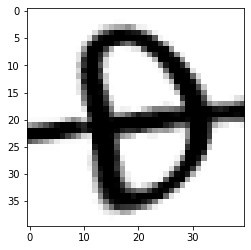

(40, 40, 1)
----augmented image  1 -----


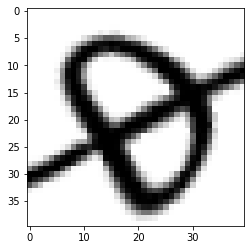

----augmented image  2 -----


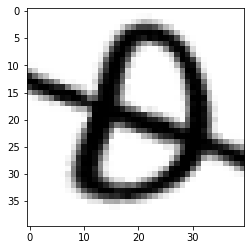

----augmented image  3 -----


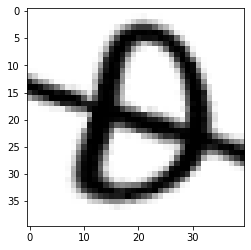

----augmented image  4 -----


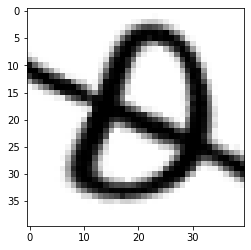

----augmented image  5 -----


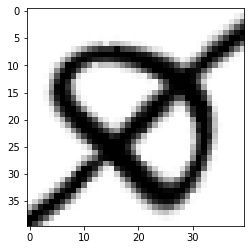

----augmented image  6 -----


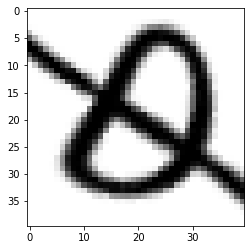

----augmented image  7 -----


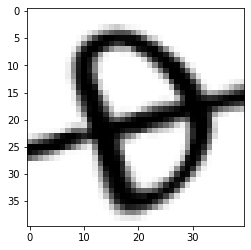

----augmented image  8 -----


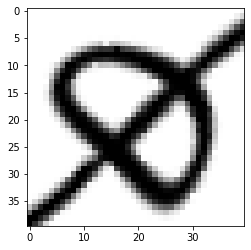

----augmented image  9 -----


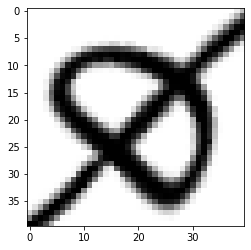

----augmented image  10 -----


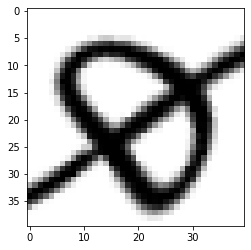

In [10]:
#single image
img = Image.open(wd + "\\images\\extracted_letters\\extracted_letter_images_left\\0\\000001.png")
print('----original image----')
plt.imshow(img, cmap="gray")
plt.show()

# convert image to np array
img_array = np.array(img)
#reshape image
img_array = img_array.reshape(40, 40 , 1)
print(img_array.shape)

for iteration in range(10): #augment 10 times
    img_rotated_array = tf.keras.preprocessing.image.random_rotation(
                    img_array, 
                    rg=40, # rotation angle
                    row_axis=1, 
                    col_axis=0, 
                    channel_axis=2, 
                    fill_mode='nearest',
                    cval=0)

    new_image = img_rotated_array.reshape(40, 40)
    print('----augmented image ', iteration + 1, '-----')
    plt.imshow(new_image, cmap="gray")
    plt.show()

## Model Training - no hyperpatameter tuning

- This is an example of training the model with augmented images.

In [66]:
LETTER_IMAGES_FOLDER =  wd + "\\images\\extracted_letters\\extracted_letter_images_left_augmented\\"
MODEL_FILENAME = wd + "\\captcha_model.hdf5"
MODEL_LABELS_FILENAME = wd + "\\model_labels.dat"

# initialize the data and labels
data = []
labels = []

In [67]:
# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    
    # Load the image and convert it to grayscale
    image = np.array(Image.open(image_file).convert("L")) # Grayscale conversion  
    #Resize the letter so it fits in a 28x28 pixel box
    image = resize_to_fit(image, 28, 28)
    
    # Add a third channel dimension to the image to make Keras happy
    image = np.expand_dims(image, axis=2)

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

In [68]:
# scale the raw pixel intensities to the range [0, 1] (this improves training)
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.3, random_state=12)
print('======X_train.shape', X_train.shape)
print('======X_test.shape', X_test.shape)
print('======Y_train.shape', Y_train.shape)
print('======Y_test.shape', Y_test.shape)


# Convert the labels (letters) into one-hot encodings that Keras can work with
lb = LabelBinarizer().fit(Y_train)
Y_train = lb.transform(Y_train)
Y_test = lb.transform(Y_test)

# Save the mapping from labels to one-hot encodings.
# We'll need this later when we use the model to decode what it's predictions mean
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(lb, f)


# build model
model = keras.models.Sequential()
model.add(Conv2D(20, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(28, 28, 1)))
model.add(Conv2D(50, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer="adam",
              metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# This callback will stop the training when there is no improvement in the validation loss for three consecutive epochs.
model.fit(X_train, Y_train,validation_data=(X_test, Y_test), batch_size=64,
          epochs=100, callbacks=[callback],verbose=1 )

# Save the trained model to disk
model.save(MODEL_FILENAME)

======X_train.shape (8414, 28, 28, 1)
======X_test.shape (3606, 28, 28, 1)
======Y_train.shape (8414,)
======Y_test.shape (3606,)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 8414 samples, validate on 3606 samples
Epoch 1/100
8414/8414 [==============================] - 9s 1ms/sample - loss: 0.2434 - acc: 0.9292 - val_loss: 0.0256 - val_acc: 0.9983
Epoch 2/100
8414/8414 [==============================] - 9s 1ms/sample - loss: 0.0179 - acc: 0.9974 - val_loss: 0.0218 - val_acc: 0.9975
Epoch 3/100
8414/8414 [==============================] - 12s 1ms/sample - loss: 0.0127 - acc: 0.9976 - val_loss: 0.0244 - val_acc: 0.9969
Epoch 4/100
8414/8414 [==============================] - 13s 2ms/sample - loss: 0.0114 - acc: 0.9977 - val_loss: 0.0243 - val_acc: 0.9972
Epoch 5/100
8414/8414 [==============================] - 12s 1ms/sample - loss: 0.0123 - acc: 0.9977 - val_loss: 0.0224 - val_acc: 0.9967


## Model Tuning - hyperparameter tuning with keras tuner

- Model was tuned using [keras tuner] (https://github.com/keras-team/keras-tuner).
- Hyperparameters that were tested includes, number of input units, number of hidden layers, dropout rate and learning rate.
- Hyperparameters tuning could take hours if not days using a CPU when a large number of parameters needs to be tuned. The example below uses a low number of trials and parameters for demonstration purposes.

In [11]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(Conv2D(filters=hp.Int('input_units', min_value=20, max_value=320, step=16),
                               kernel_size= (3,3),
                               input_shape=(28, 28, 1), 
                               activation="relu"))

    
    for i in range(hp.Int("n_layers", 1, 2)):
        model.add(Conv2D(filters=hp.Int(f"conv_{i}_units", min_value=32, max_value=256, step=32),
                           kernel_size= (3,3),
                           activation="relu"))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
        
    model.add(Flatten())
    
    model.add(Dense(units=hp.Int('dense_1_units', min_value=20, max_value=640, step=32), activation='relu'))
    
    model.add(Dropout(hp.Float('dropout',min_value=0,max_value=0.5,step=0.1)))
    
    model.add(Dense(10, activation='softmax'))

    model.compile(
    optimizer=keras.optimizers.Adam(hp.Float('learning_rate',
                                            min_value=1e-4,
                                            max_value=1e-2,
                                            sampling='LOG',
                                            default=1e-3)
                                    ),
                                    loss=keras.losses.categorical_crossentropy,
                                    metrics=['accuracy']
                                )

    return model
  

In [83]:
tuner = RandomSearch(
         build_model,
         objective='val_acc',
    #objective='val_accuracy',
         max_trials=2,
         executions_per_trial=1,
        directory=os.path.normpath('C:/Users/kohsi/Desktop/'),
        project_name='captcha_20200409')

tuner.search(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

INFO:tensorflow:Reloading Oracle from existing project C:\Users\kohsi\Desktop\captcha_20200409\oracle.json
Train on 8414 samples, validate on 3606 samples
Epoch 1/5
6880/8414 [=======================>......] - ETA: 1:06 - loss: 2.3179 - acc: 0.125 - ETA: 57s - loss: 2.3183 - acc: 0.109 - ETA: 53s - loss: 2.3287 - acc: 0.10 - ETA: 52s - loss: 2.3086 - acc: 0.12 - ETA: 50s - loss: 2.2907 - acc: 0.15 - ETA: 49s - loss: 2.3056 - acc: 0.12 - ETA: 48s - loss: 2.3001 - acc: 0.12 - ETA: 48s - loss: 2.2917 - acc: 0.13 - ETA: 47s - loss: 2.2803 - acc: 0.16 - ETA: 47s - loss: 2.2731 - acc: 0.18 - ETA: 46s - loss: 2.2651 - acc: 0.19 - ETA: 46s - loss: 2.2589 - acc: 0.20 - ETA: 46s - loss: 2.2527 - acc: 0.20 - ETA: 46s - loss: 2.2489 - acc: 0.20 - ETA: 45s - loss: 2.2255 - acc: 0.23 - ETA: 45s - loss: 2.2117 - acc: 0.25 - ETA: 45s - loss: 2.2042 - acc: 0.24 - ETA: 45s - loss: 2.1840 - acc: 0.25 - ETA: 46s - loss: 2.1561 - acc: 0.26 - ETA: 45s - loss: 2.1401 - acc: 0.26 - ETA: 45s - loss: 2.1273 - a

6816/8414 [=======================>......] - ETA: 1:09 - loss: 0.0131 - acc: 1.000 - ETA: 1:06 - loss: 0.0329 - acc: 0.984 - ETA: 1:06 - loss: 0.0244 - acc: 0.989 - ETA: 1:08 - loss: 0.0246 - acc: 0.992 - ETA: 1:08 - loss: 0.0232 - acc: 0.993 - ETA: 1:09 - loss: 0.0333 - acc: 0.989 - ETA: 1:10 - loss: 0.0298 - acc: 0.991 - ETA: 1:09 - loss: 0.0290 - acc: 0.992 - ETA: 1:08 - loss: 0.0272 - acc: 0.993 - ETA: 1:08 - loss: 0.0290 - acc: 0.990 - ETA: 1:07 - loss: 0.0266 - acc: 0.991 - ETA: 1:07 - loss: 0.0252 - acc: 0.992 - ETA: 1:06 - loss: 0.0247 - acc: 0.992 - ETA: 1:06 - loss: 0.0245 - acc: 0.993 - ETA: 1:05 - loss: 0.0307 - acc: 0.991 - ETA: 1:05 - loss: 0.0345 - acc: 0.990 - ETA: 1:05 - loss: 0.0331 - acc: 0.990 - ETA: 1:05 - loss: 0.0319 - acc: 0.991 - ETA: 1:05 - loss: 0.0309 - acc: 0.991 - ETA: 1:04 - loss: 0.0298 - acc: 0.992 - ETA: 1:04 - loss: 0.0314 - acc: 0.991 - ETA: 1:04 - loss: 0.0303 - acc: 0.991 - ETA: 1:04 - loss: 0.0292 - acc: 0.991 - ETA: 1:03 - loss: 0.0289 - acc: 0.9

8414/8414 [==============================] - ETA: 12s - loss: 0.0351 - acc: 0.99 - ETA: 12s - loss: 0.0350 - acc: 0.99 - ETA: 12s - loss: 0.0348 - acc: 0.99 - ETA: 11s - loss: 0.0347 - acc: 0.99 - ETA: 11s - loss: 0.0346 - acc: 0.99 - ETA: 11s - loss: 0.0344 - acc: 0.99 - ETA: 11s - loss: 0.0343 - acc: 0.99 - ETA: 10s - loss: 0.0341 - acc: 0.99 - ETA: 10s - loss: 0.0341 - acc: 0.99 - ETA: 10s - loss: 0.0340 - acc: 0.99 - ETA: 10s - loss: 0.0338 - acc: 0.99 - ETA: 9s - loss: 0.0338 - acc: 0.9918 - ETA: 9s - loss: 0.0337 - acc: 0.991 - ETA: 9s - loss: 0.0336 - acc: 0.991 - ETA: 9s - loss: 0.0337 - acc: 0.991 - ETA: 8s - loss: 0.0336 - acc: 0.991 - ETA: 8s - loss: 0.0335 - acc: 0.991 - ETA: 8s - loss: 0.0335 - acc: 0.991 - ETA: 8s - loss: 0.0334 - acc: 0.991 - ETA: 7s - loss: 0.0333 - acc: 0.992 - ETA: 7s - loss: 0.0332 - acc: 0.992 - ETA: 7s - loss: 0.0331 - acc: 0.992 - ETA: 6s - loss: 0.0330 - acc: 0.992 - ETA: 6s - loss: 0.0328 - acc: 0.992 - ETA: 6s - loss: 0.0327 - acc: 0.992 - ETA:

6816/8414 [=======================>......] - ETA: 1:10 - loss: 0.0038 - acc: 1.000 - ETA: 1:09 - loss: 0.0023 - acc: 1.000 - ETA: 1:10 - loss: 0.0021 - acc: 1.000 - ETA: 1:10 - loss: 0.0044 - acc: 1.000 - ETA: 1:11 - loss: 0.0036 - acc: 1.000 - ETA: 1:15 - loss: 0.0034 - acc: 1.000 - ETA: 1:14 - loss: 0.0033 - acc: 1.000 - ETA: 1:13 - loss: 0.0031 - acc: 1.000 - ETA: 1:12 - loss: 0.0032 - acc: 1.000 - ETA: 1:11 - loss: 0.0051 - acc: 1.000 - ETA: 1:11 - loss: 0.0049 - acc: 1.000 - ETA: 1:10 - loss: 0.0049 - acc: 1.000 - ETA: 1:09 - loss: 0.0047 - acc: 1.000 - ETA: 1:10 - loss: 0.0044 - acc: 1.000 - ETA: 1:10 - loss: 0.0044 - acc: 1.000 - ETA: 1:10 - loss: 0.0042 - acc: 1.000 - ETA: 1:10 - loss: 0.0041 - acc: 1.000 - ETA: 1:09 - loss: 0.0041 - acc: 1.000 - ETA: 1:08 - loss: 0.0040 - acc: 1.000 - ETA: 1:07 - loss: 0.0044 - acc: 1.000 - ETA: 1:07 - loss: 0.0042 - acc: 1.000 - ETA: 1:06 - loss: 0.0040 - acc: 1.000 - ETA: 1:06 - loss: 0.0039 - acc: 1.000 - ETA: 1:05 - loss: 0.0038 - acc: 1.0

8414/8414 [==============================] - ETA: 13s - loss: 0.0155 - acc: 0.99 - ETA: 13s - loss: 0.0156 - acc: 0.99 - ETA: 13s - loss: 0.0155 - acc: 0.99 - ETA: 12s - loss: 0.0155 - acc: 0.99 - ETA: 12s - loss: 0.0154 - acc: 0.99 - ETA: 12s - loss: 0.0154 - acc: 0.99 - ETA: 12s - loss: 0.0157 - acc: 0.99 - ETA: 11s - loss: 0.0157 - acc: 0.99 - ETA: 11s - loss: 0.0156 - acc: 0.99 - ETA: 11s - loss: 0.0155 - acc: 0.99 - ETA: 10s - loss: 0.0155 - acc: 0.99 - ETA: 10s - loss: 0.0155 - acc: 0.99 - ETA: 10s - loss: 0.0154 - acc: 0.99 - ETA: 10s - loss: 0.0154 - acc: 0.99 - ETA: 9s - loss: 0.0153 - acc: 0.9959 - ETA: 9s - loss: 0.0152 - acc: 0.995 - ETA: 9s - loss: 0.0152 - acc: 0.995 - ETA: 8s - loss: 0.0152 - acc: 0.995 - ETA: 8s - loss: 0.0151 - acc: 0.996 - ETA: 8s - loss: 0.0150 - acc: 0.996 - ETA: 8s - loss: 0.0150 - acc: 0.996 - ETA: 7s - loss: 0.0149 - acc: 0.996 - ETA: 7s - loss: 0.0149 - acc: 0.996 - ETA: 7s - loss: 0.0148 - acc: 0.996 - ETA: 6s - loss: 0.0147 - acc: 0.996 - ETA:

Train on 8414 samples, validate on 3606 samples
Epoch 1/5
6560/8414 [======================>.......] - ETA: 2:25 - loss: 2.3294 - acc: 0.031 - ETA: 2:20 - loss: 2.3861 - acc: 0.062 - ETA: 2:18 - loss: 2.3906 - acc: 0.083 - ETA: 2:17 - loss: 2.3733 - acc: 0.085 - ETA: 2:17 - loss: 2.3512 - acc: 0.106 - ETA: 2:17 - loss: 2.3337 - acc: 0.161 - ETA: 2:16 - loss: 2.3203 - acc: 0.187 - ETA: 2:16 - loss: 2.3014 - acc: 0.214 - ETA: 2:16 - loss: 2.2769 - acc: 0.243 - ETA: 2:15 - loss: 2.2638 - acc: 0.262 - ETA: 2:16 - loss: 2.2461 - acc: 0.286 - ETA: 2:18 - loss: 2.2272 - acc: 0.317 - ETA: 2:18 - loss: 2.2041 - acc: 0.331 - ETA: 2:17 - loss: 2.1687 - acc: 0.354 - ETA: 2:17 - loss: 2.1503 - acc: 0.358 - ETA: 2:17 - loss: 2.1240 - acc: 0.365 - ETA: 2:17 - loss: 2.0863 - acc: 0.382 - ETA: 2:16 - loss: 2.0455 - acc: 0.401 - ETA: 2:15 - loss: 2.0114 - acc: 0.419 - ETA: 2:15 - loss: 1.9633 - acc: 0.440 - ETA: 2:14 - loss: 1.9195 - acc: 0.452 - ETA: 2:15 - loss: 1.8818 - acc: 0.463 - ETA: 2:16 - loss:

6624/8414 [======================>.......] - ETA: 1:56 - loss: 0.0050 - acc: 1.000 - ETA: 2:07 - loss: 0.0064 - acc: 1.000 - ETA: 2:11 - loss: 0.0087 - acc: 1.000 - ETA: 2:10 - loss: 0.0073 - acc: 1.000 - ETA: 2:11 - loss: 0.0066 - acc: 1.000 - ETA: 2:10 - loss: 0.0059 - acc: 1.000 - ETA: 2:11 - loss: 0.0141 - acc: 0.995 - ETA: 2:10 - loss: 0.0129 - acc: 0.996 - ETA: 2:10 - loss: 0.0116 - acc: 0.996 - ETA: 2:10 - loss: 0.0113 - acc: 0.996 - ETA: 2:09 - loss: 0.0110 - acc: 0.997 - ETA: 2:09 - loss: 0.0104 - acc: 0.997 - ETA: 2:08 - loss: 0.0101 - acc: 0.997 - ETA: 2:08 - loss: 0.0115 - acc: 0.995 - ETA: 2:07 - loss: 0.0109 - acc: 0.995 - ETA: 2:07 - loss: 0.0103 - acc: 0.996 - ETA: 2:06 - loss: 0.0102 - acc: 0.996 - ETA: 2:07 - loss: 0.0098 - acc: 0.996 - ETA: 2:06 - loss: 0.0094 - acc: 0.996 - ETA: 2:05 - loss: 0.0092 - acc: 0.996 - ETA: 2:05 - loss: 0.0093 - acc: 0.997 - ETA: 2:04 - loss: 0.0096 - acc: 0.997 - ETA: 2:04 - loss: 0.0092 - acc: 0.997 - ETA: 2:04 - loss: 0.0091 - acc: 0.9

8414/8414 [==============================] - ETA: 28s - loss: 0.0179 - acc: 0.99 - ETA: 28s - loss: 0.0179 - acc: 0.99 - ETA: 27s - loss: 0.0180 - acc: 0.99 - ETA: 27s - loss: 0.0179 - acc: 0.99 - ETA: 26s - loss: 0.0180 - acc: 0.99 - ETA: 26s - loss: 0.0179 - acc: 0.99 - ETA: 25s - loss: 0.0178 - acc: 0.99 - ETA: 25s - loss: 0.0178 - acc: 0.99 - ETA: 24s - loss: 0.0177 - acc: 0.99 - ETA: 24s - loss: 0.0176 - acc: 0.99 - ETA: 23s - loss: 0.0176 - acc: 0.99 - ETA: 22s - loss: 0.0176 - acc: 0.99 - ETA: 22s - loss: 0.0175 - acc: 0.99 - ETA: 21s - loss: 0.0175 - acc: 0.99 - ETA: 21s - loss: 0.0174 - acc: 0.99 - ETA: 20s - loss: 0.0173 - acc: 0.99 - ETA: 20s - loss: 0.0172 - acc: 0.99 - ETA: 19s - loss: 0.0172 - acc: 0.99 - ETA: 19s - loss: 0.0171 - acc: 0.99 - ETA: 18s - loss: 0.0170 - acc: 0.99 - ETA: 18s - loss: 0.0170 - acc: 0.99 - ETA: 17s - loss: 0.0169 - acc: 0.99 - ETA: 17s - loss: 0.0168 - acc: 0.99 - ETA: 16s - loss: 0.0168 - acc: 0.99 - ETA: 16s - loss: 0.0167 - acc: 0.99 - ETA: 

6624/8414 [======================>.......] - ETA: 2:25 - loss: 0.0029 - acc: 1.000 - ETA: 2:19 - loss: 0.0033 - acc: 1.000 - ETA: 2:19 - loss: 0.0043 - acc: 1.000 - ETA: 2:16 - loss: 0.0033 - acc: 1.000 - ETA: 2:16 - loss: 0.0028 - acc: 1.000 - ETA: 2:15 - loss: 0.0096 - acc: 0.994 - ETA: 2:15 - loss: 0.0088 - acc: 0.995 - ETA: 2:13 - loss: 0.0081 - acc: 0.996 - ETA: 2:13 - loss: 0.0072 - acc: 0.996 - ETA: 2:12 - loss: 0.0070 - acc: 0.996 - ETA: 2:12 - loss: 0.0065 - acc: 0.997 - ETA: 2:11 - loss: 0.0060 - acc: 0.997 - ETA: 2:11 - loss: 0.0064 - acc: 0.997 - ETA: 2:10 - loss: 0.0061 - acc: 0.997 - ETA: 2:10 - loss: 0.0061 - acc: 0.997 - ETA: 2:09 - loss: 0.0067 - acc: 0.998 - ETA: 2:08 - loss: 0.0063 - acc: 0.998 - ETA: 2:08 - loss: 0.0060 - acc: 0.998 - ETA: 2:07 - loss: 0.0058 - acc: 0.998 - ETA: 2:07 - loss: 0.0055 - acc: 0.998 - ETA: 2:06 - loss: 0.0053 - acc: 0.998 - ETA: 2:06 - loss: 0.0051 - acc: 0.998 - ETA: 2:05 - loss: 0.0049 - acc: 0.998 - ETA: 2:04 - loss: 0.0047 - acc: 0.9

8414/8414 [==============================] - ETA: 28s - loss: 0.0100 - acc: 0.99 - ETA: 28s - loss: 0.0100 - acc: 0.99 - ETA: 27s - loss: 0.0100 - acc: 0.99 - ETA: 27s - loss: 0.0099 - acc: 0.99 - ETA: 26s - loss: 0.0099 - acc: 0.99 - ETA: 26s - loss: 0.0101 - acc: 0.99 - ETA: 25s - loss: 0.0100 - acc: 0.99 - ETA: 25s - loss: 0.0101 - acc: 0.99 - ETA: 24s - loss: 0.0100 - acc: 0.99 - ETA: 24s - loss: 0.0100 - acc: 0.99 - ETA: 23s - loss: 0.0100 - acc: 0.99 - ETA: 23s - loss: 0.0099 - acc: 0.99 - ETA: 22s - loss: 0.0099 - acc: 0.99 - ETA: 22s - loss: 0.0099 - acc: 0.99 - ETA: 21s - loss: 0.0098 - acc: 0.99 - ETA: 20s - loss: 0.0098 - acc: 0.99 - ETA: 20s - loss: 0.0098 - acc: 0.99 - ETA: 19s - loss: 0.0097 - acc: 0.99 - ETA: 19s - loss: 0.0097 - acc: 0.99 - ETA: 18s - loss: 0.0096 - acc: 0.99 - ETA: 18s - loss: 0.0096 - acc: 0.99 - ETA: 17s - loss: 0.0096 - acc: 0.99 - ETA: 17s - loss: 0.0095 - acc: 0.99 - ETA: 16s - loss: 0.0095 - acc: 0.99 - ETA: 16s - loss: 0.0095 - acc: 0.99 - ETA: 

INFO:tensorflow:Oracle triggered exit


- the follwing functions show the best model

In [85]:
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 164, 'n_layers': 1, 'conv_0_units': 160, 'dense_1_units': 52, 'dropout': 0.1, 'learning_rate': 0.000742273365279094}


In [86]:
print(tuner.get_best_models()[0].summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 164)       1640      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 160)       236320    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 160)       0         
_________________________________________________________________
flatten (Flatten)            (None, 23040)             0         
_________________________________________________________________
dense (Dense)                (None, 52)                1198132   
_________________________________________________________________
dropout (Dropout)            (None, 52)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

## predict new image function

In [40]:
# function to predict 4 letters
def captcha_solver(img_path, size_x, size_y, model):

    predictions = []

    # Load the image and convert it to grayscale and then numpy array
    image = Image.open(img_path).convert("L") # Grayscale conversion 
    cropped_image1 = np.array(image.crop((10, 0, 50, 70)))
    cropped_image2 = np.array(image.crop((45, 0, 85, 70)))
    cropped_image3 = np.array(image.crop((80, 0, 120, 70)))
    cropped_image4 = np.array(image.crop((120, 0, 160, 70)))
    
    cropped_image = [cropped_image1, cropped_image2, cropped_image3, cropped_image4]

    # Save out each letter as a single image
    for ind_img in cropped_image:
        image = img_process(ind_img, size_x, size_y)
        # Add a third channel dimension to the image to make Keras happy
        image = np.expand_dims(image, axis=2)
        image = np.expand_dims(image, axis=0)

        # Ask the neural network to make a prediction
        prediction = model.predict(image)
        letter = lb.inverse_transform(prediction)[0]
        predictions.append(letter)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    
    return captcha_text

In [41]:
import warnings
warnings.filterwarnings('ignore')

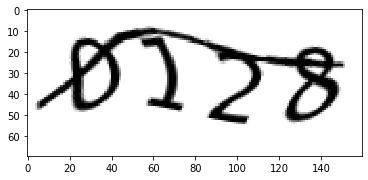

'0128'

In [42]:
model_label_path = wd + '\\model\\model_labels.dat'
model_path = wd + '\\model\\captcha_model.hdf5'
img_path = wd + '\\images\\\labeled\\labeled_validation\\left_newimages_1\\0128.jpg'

# Load up the model labels (so we can translate model predictions to actual letters)
with open(model_label_path, "rb") as f:
    lb = pickle.load(f)
model = tf.keras.models.load_model(model_path)

#show image
image = Image.open(img_path).convert("L") # Grayscale conversion 
plt.imshow(image, cmap="gray")
plt.show()

#predict image
captcha_solver(img_path, 28, 28, model)

## Compute accuracy

- compute accuracy for validation images (model has not seen before)

In [48]:
img_folders_path = wd + '\\images\\labeled\labeled_validation\\'
img_folders = glob.glob(img_folders_path + "*")
correct_count = 0
total_count = 0
wrongly_classified_file = []


for folder in img_folders:

    # Get a list of all the captcha images we need to process
    captcha_image_files = glob.glob(folder + "\\*")

    # loop over the image paths
    for (i, captcha_image_file) in enumerate(captcha_image_files):
        print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
        filename = os.path.basename(captcha_image_file)
        correct_captcha_text = os.path.splitext(filename)[0]
        img_path = folder + '\\' + filename 
        print('correct_captcha_text', correct_captcha_text)

        pred = captcha_solver(img_path, 28, 28, model)
        print('predicted', pred)

        if pred == correct_captcha_text:
            correct_count += 1
        else:
            wrongly_classified_file.append(filename)
        
    total_count += len(captcha_image_files)

    
print('====================')
accuracy = round(correct_count/total_count*100, 2)
print('Accuracy is ', correct_count, 'out of', total_count, ' ,or', accuracy, '%')

[INFO] processing image 1/644
correct_captcha_text 0128
predicted 0128
[INFO] processing image 2/644
correct_captcha_text 0249
predicted 0249
[INFO] processing image 3/644
correct_captcha_text 0295
predicted 0295
[INFO] processing image 4/644
correct_captcha_text 0377
predicted 0377
[INFO] processing image 5/644
correct_captcha_text 0417
predicted 0417
[INFO] processing image 6/644
correct_captcha_text 0622
predicted 0622
[INFO] processing image 7/644
correct_captcha_text 0700
predicted 0700
[INFO] processing image 8/644
correct_captcha_text 0705
predicted 0705
[INFO] processing image 9/644
correct_captcha_text 0839
predicted 0839
[INFO] processing image 10/644
correct_captcha_text 1058
predicted 1058
[INFO] processing image 11/644
correct_captcha_text 1122
predicted 1122
[INFO] processing image 12/644
correct_captcha_text 1129
predicted 1129
[INFO] processing image 13/644
correct_captcha_text 1217
predicted 1217
[INFO] processing image 14/644
correct_captcha_text 1543
predicted 1543
[

correct_captcha_text 5602
predicted 5602
[INFO] processing image 115/644
correct_captcha_text 5609
predicted 5609
[INFO] processing image 116/644
correct_captcha_text 5611
predicted 5611
[INFO] processing image 117/644
correct_captcha_text 5631
predicted 5631
[INFO] processing image 118/644
correct_captcha_text 5640
predicted 5640
[INFO] processing image 119/644
correct_captcha_text 5650
predicted 5650
[INFO] processing image 120/644
correct_captcha_text 5665
predicted 5665
[INFO] processing image 121/644
correct_captcha_text 5666
predicted 5666
[INFO] processing image 122/644
correct_captcha_text 5677
predicted 5677
[INFO] processing image 123/644
correct_captcha_text 5687
predicted 5687
[INFO] processing image 124/644
correct_captcha_text 5703
predicted 5703
[INFO] processing image 125/644
correct_captcha_text 5708
predicted 5708
[INFO] processing image 126/644
correct_captcha_text 5713
predicted 5713
[INFO] processing image 127/644
correct_captcha_text 5725
predicted 5725
[INFO] pro

correct_captcha_text 6610
predicted 6610
[INFO] processing image 227/644
correct_captcha_text 6617
predicted 6617
[INFO] processing image 228/644
correct_captcha_text 6649
predicted 6649
[INFO] processing image 229/644
correct_captcha_text 6654
predicted 6654
[INFO] processing image 230/644
correct_captcha_text 6661
predicted 6661
[INFO] processing image 231/644
correct_captcha_text 6675
predicted 6675
[INFO] processing image 232/644
correct_captcha_text 6680
predicted 6680
[INFO] processing image 233/644
correct_captcha_text 6688
predicted 6688
[INFO] processing image 234/644
correct_captcha_text 6694
predicted 6694
[INFO] processing image 235/644
correct_captcha_text 6699
predicted 6699
[INFO] processing image 236/644
correct_captcha_text 6704
predicted 6704
[INFO] processing image 237/644
correct_captcha_text 6706
predicted 6706
[INFO] processing image 238/644
correct_captcha_text 6708
predicted 6708
[INFO] processing image 239/644
correct_captcha_text 6709
predicted 6709
[INFO] pro

correct_captcha_text 7450
predicted 7450
[INFO] processing image 339/644
correct_captcha_text 7459
predicted 7759
[INFO] processing image 340/644
correct_captcha_text 7479
predicted 7419
[INFO] processing image 341/644
correct_captcha_text 7488
predicted 7488
[INFO] processing image 342/644
correct_captcha_text 7489
predicted 7489
[INFO] processing image 343/644
correct_captcha_text 7510
predicted 7510
[INFO] processing image 344/644
correct_captcha_text 7515
predicted 7515
[INFO] processing image 345/644
correct_captcha_text 7521
predicted 7521
[INFO] processing image 346/644
correct_captcha_text 7525
predicted 7525
[INFO] processing image 347/644
correct_captcha_text 7545
predicted 7545
[INFO] processing image 348/644
correct_captcha_text 7547
predicted 7547
[INFO] processing image 349/644
correct_captcha_text 7554
predicted 7554
[INFO] processing image 350/644
correct_captcha_text 7565
predicted 7565
[INFO] processing image 351/644
correct_captcha_text 7571
predicted 7571
[INFO] pro

correct_captcha_text 8394
predicted 8394
[INFO] processing image 451/644
correct_captcha_text 8396
predicted 8396
[INFO] processing image 452/644
correct_captcha_text 8397
predicted 8397
[INFO] processing image 453/644
correct_captcha_text 8413
predicted 8413
[INFO] processing image 454/644
correct_captcha_text 8424
predicted 8424
[INFO] processing image 455/644
correct_captcha_text 8427
predicted 8427
[INFO] processing image 456/644
correct_captcha_text 8437
predicted 8437
[INFO] processing image 457/644
correct_captcha_text 8449
predicted 8449
[INFO] processing image 458/644
correct_captcha_text 8467
predicted 8467
[INFO] processing image 459/644
correct_captcha_text 8472
predicted 8472
[INFO] processing image 460/644
correct_captcha_text 8473
predicted 8473
[INFO] processing image 461/644
correct_captcha_text 8484
predicted 8484
[INFO] processing image 462/644
correct_captcha_text 8493
predicted 8493
[INFO] processing image 463/644
correct_captcha_text 8496
predicted 8496
[INFO] pro

correct_captcha_text 9340
predicted 9340
[INFO] processing image 563/644
correct_captcha_text 9341
predicted 9341
[INFO] processing image 564/644
correct_captcha_text 9343
predicted 9343
[INFO] processing image 565/644
correct_captcha_text 9366
predicted 9366
[INFO] processing image 566/644
correct_captcha_text 9367
predicted 9367
[INFO] processing image 567/644
correct_captcha_text 9376
predicted 9376
[INFO] processing image 568/644
correct_captcha_text 9377
predicted 9377
[INFO] processing image 569/644
correct_captcha_text 9386
predicted 9386
[INFO] processing image 570/644
correct_captcha_text 9389
predicted 9389
[INFO] processing image 571/644
correct_captcha_text 9394
predicted 9394
[INFO] processing image 572/644
correct_captcha_text 9402
predicted 9402
[INFO] processing image 573/644
correct_captcha_text 9413
predicted 9413
[INFO] processing image 574/644
correct_captcha_text 9422
predicted 9422
[INFO] processing image 575/644
correct_captcha_text 9433
predicted 9433
[INFO] pro

[INFO] processing image 31/533
correct_captcha_text 0280
predicted 0280
[INFO] processing image 32/533
correct_captcha_text 0281
predicted 0281
[INFO] processing image 33/533
correct_captcha_text 0283
predicted 0283
[INFO] processing image 34/533
correct_captcha_text 0295
predicted 0295
[INFO] processing image 35/533
correct_captcha_text 0313
predicted 0313
[INFO] processing image 36/533
correct_captcha_text 0323
predicted 0323
[INFO] processing image 37/533
correct_captcha_text 0329
predicted 0329
[INFO] processing image 38/533
correct_captcha_text 0342
predicted 0342
[INFO] processing image 39/533
correct_captcha_text 0354
predicted 0354
[INFO] processing image 40/533
correct_captcha_text 0366
predicted 0366
[INFO] processing image 41/533
correct_captcha_text 0368
predicted 0368
[INFO] processing image 42/533
correct_captcha_text 0377
predicted 0377
[INFO] processing image 43/533
correct_captcha_text 0385
predicted 0385
[INFO] processing image 44/533
correct_captcha_text 0387
predict

[INFO] processing image 144/533
correct_captcha_text 1217
predicted 1217
[INFO] processing image 145/533
correct_captcha_text 1223
predicted 1223
[INFO] processing image 146/533
correct_captcha_text 1237
predicted 1237
[INFO] processing image 147/533
correct_captcha_text 1238
predicted 1238
[INFO] processing image 148/533
correct_captcha_text 1239
predicted 1239
[INFO] processing image 149/533
correct_captcha_text 1256
predicted 1256
[INFO] processing image 150/533
correct_captcha_text 1260
predicted 1260
[INFO] processing image 151/533
correct_captcha_text 1265
predicted 1265
[INFO] processing image 152/533
correct_captcha_text 1266
predicted 1266
[INFO] processing image 153/533
correct_captcha_text 1297
predicted 1297
[INFO] processing image 154/533
correct_captcha_text 1305
predicted 1305
[INFO] processing image 155/533
correct_captcha_text 1317
predicted 1317
[INFO] processing image 156/533
correct_captcha_text 1326
predicted 1326
[INFO] processing image 157/533
correct_captcha_tex

[INFO] processing image 256/533
correct_captcha_text 2229
predicted 2279
[INFO] processing image 257/533
correct_captcha_text 2240
predicted 2240
[INFO] processing image 258/533
correct_captcha_text 2253
predicted 2253
[INFO] processing image 259/533
correct_captcha_text 2273
predicted 2273
[INFO] processing image 260/533
correct_captcha_text 2276
predicted 2276
[INFO] processing image 261/533
correct_captcha_text 2323
predicted 2323
[INFO] processing image 262/533
correct_captcha_text 2337
predicted 2337
[INFO] processing image 263/533
correct_captcha_text 2340
predicted 2340
[INFO] processing image 264/533
correct_captcha_text 2350
predicted 2350
[INFO] processing image 265/533
correct_captcha_text 2351
predicted 2351
[INFO] processing image 266/533
correct_captcha_text 2358
predicted 2358
[INFO] processing image 267/533
correct_captcha_text 2393
predicted 2393
[INFO] processing image 268/533
correct_captcha_text 2406
predicted 2406
[INFO] processing image 269/533
correct_captcha_tex

[INFO] processing image 368/533
correct_captcha_text 3386
predicted 3386
[INFO] processing image 369/533
correct_captcha_text 3398
predicted 3398
[INFO] processing image 370/533
correct_captcha_text 3400
predicted 3400
[INFO] processing image 371/533
correct_captcha_text 3427
predicted 3427
[INFO] processing image 372/533
correct_captcha_text 3431
predicted 3431
[INFO] processing image 373/533
correct_captcha_text 3459
predicted 3459
[INFO] processing image 374/533
correct_captcha_text 3468
predicted 3468
[INFO] processing image 375/533
correct_captcha_text 3487
predicted 3487
[INFO] processing image 376/533
correct_captcha_text 3492
predicted 3492
[INFO] processing image 377/533
correct_captcha_text 3504
predicted 3504
[INFO] processing image 378/533
correct_captcha_text 3510
predicted 3510
[INFO] processing image 379/533
correct_captcha_text 3523
predicted 3523
[INFO] processing image 380/533
correct_captcha_text 3540
predicted 3540
[INFO] processing image 381/533
correct_captcha_tex

[INFO] processing image 480/533
correct_captcha_text 4483
predicted 4483
[INFO] processing image 481/533
correct_captcha_text 4497
predicted 4497
[INFO] processing image 482/533
correct_captcha_text 4499
predicted 4499
[INFO] processing image 483/533
correct_captcha_text 4549
predicted 4549
[INFO] processing image 484/533
correct_captcha_text 4552
predicted 4552
[INFO] processing image 485/533
correct_captcha_text 4553
predicted 4553
[INFO] processing image 486/533
correct_captcha_text 4559
predicted 4559
[INFO] processing image 487/533
correct_captcha_text 4563
predicted 4563
[INFO] processing image 488/533
correct_captcha_text 4566
predicted 4566
[INFO] processing image 489/533
correct_captcha_text 4574
predicted 4574
[INFO] processing image 490/533
correct_captcha_text 4577
predicted 4577
[INFO] processing image 491/533
correct_captcha_text 4587
predicted 4587
[INFO] processing image 492/533
correct_captcha_text 4601
predicted 4601
[INFO] processing image 493/533
correct_captcha_tex

[INFO] processing image 60/653
correct_captcha_text 1472
predicted 1473
[INFO] processing image 61/653
correct_captcha_text 1476
predicted 1476
[INFO] processing image 62/653
correct_captcha_text 1479
predicted 1479
[INFO] processing image 63/653
correct_captcha_text 1483
predicted 1483
[INFO] processing image 64/653
correct_captcha_text 1489
predicted 1487
[INFO] processing image 65/653
correct_captcha_text 1499
predicted 1499
[INFO] processing image 66/653
correct_captcha_text 1524
predicted 1524
[INFO] processing image 67/653
correct_captcha_text 1532
predicted 1532
[INFO] processing image 68/653
correct_captcha_text 1561
predicted 1561
[INFO] processing image 69/653
correct_captcha_text 1569
predicted 1569
[INFO] processing image 70/653
correct_captcha_text 1591
predicted 1591
[INFO] processing image 71/653
correct_captcha_text 1592
predicted 1587
[INFO] processing image 72/653
correct_captcha_text 1594
predicted 1594
[INFO] processing image 73/653
correct_captcha_text 1612
predict

correct_captcha_text 3216
predicted 3216
[INFO] processing image 173/653
correct_captcha_text 3221
predicted 3221
[INFO] processing image 174/653
correct_captcha_text 3223
predicted 3223
[INFO] processing image 175/653
correct_captcha_text 3239
predicted 3239
[INFO] processing image 176/653
correct_captcha_text 3252
predicted 3253
[INFO] processing image 177/653
correct_captcha_text 3275
predicted 3275
[INFO] processing image 178/653
correct_captcha_text 3286
predicted 3286
[INFO] processing image 179/653
correct_captcha_text 3294
predicted 3294
[INFO] processing image 180/653
correct_captcha_text 3300
predicted 3307
[INFO] processing image 181/653
correct_captcha_text 3301
predicted 3301
[INFO] processing image 182/653
correct_captcha_text 3305
predicted 3305
[INFO] processing image 183/653
correct_captcha_text 3331
predicted 3331
[INFO] processing image 184/653
correct_captcha_text 3338
predicted 3338
[INFO] processing image 185/653
correct_captcha_text 3344
predicted 3344
[INFO] pro

correct_captcha_text 4674
predicted 4674
[INFO] processing image 285/653
correct_captcha_text 4680
predicted 4680
[INFO] processing image 286/653
correct_captcha_text 4683
predicted 4683
[INFO] processing image 287/653
correct_captcha_text 4709
predicted 4709
[INFO] processing image 288/653
correct_captcha_text 4749
predicted 4749
[INFO] processing image 289/653
correct_captcha_text 4758
predicted 4758
[INFO] processing image 290/653
correct_captcha_text 4759
predicted 4759
[INFO] processing image 291/653
correct_captcha_text 4761
predicted 4761
[INFO] processing image 292/653
correct_captcha_text 4808
predicted 4808
[INFO] processing image 293/653
correct_captcha_text 4811
predicted 4811
[INFO] processing image 294/653
correct_captcha_text 4820
predicted 4820
[INFO] processing image 295/653
correct_captcha_text 4832
predicted 4832
[INFO] processing image 296/653
correct_captcha_text 4834
predicted 4834
[INFO] processing image 297/653
correct_captcha_text 4840
predicted 4847
[INFO] pro

correct_captcha_text 6545
predicted 6545
[INFO] processing image 397/653
correct_captcha_text 6548
predicted 6545
[INFO] processing image 398/653
correct_captcha_text 6554
predicted 6554
[INFO] processing image 399/653
correct_captcha_text 6564
predicted 6564
[INFO] processing image 400/653
correct_captcha_text 6568
predicted 6565
[INFO] processing image 401/653
correct_captcha_text 6584
predicted 6584
[INFO] processing image 402/653
correct_captcha_text 6589
predicted 6587
[INFO] processing image 403/653
correct_captcha_text 6642
predicted 6642
[INFO] processing image 404/653
correct_captcha_text 6667
predicted 6667
[INFO] processing image 405/653
correct_captcha_text 6675
predicted 6675
[INFO] processing image 406/653
correct_captcha_text 6678
predicted 6675
[INFO] processing image 407/653
correct_captcha_text 6693
predicted 6693
[INFO] processing image 408/653
correct_captcha_text 6704
predicted 6704
[INFO] processing image 409/653
correct_captcha_text 6720
predicted 6727
[INFO] pro

correct_captcha_text 7859
predicted 7857
[INFO] processing image 509/653
correct_captcha_text 7861
predicted 7861
[INFO] processing image 510/653
correct_captcha_text 7879
predicted 7879
[INFO] processing image 511/653
correct_captcha_text 7881
predicted 7881
[INFO] processing image 512/653
correct_captcha_text 7920
predicted 7927
[INFO] processing image 513/653
correct_captcha_text 7931
predicted 7931
[INFO] processing image 514/653
correct_captcha_text 7963
predicted 7963
[INFO] processing image 515/653
correct_captcha_text 7964
predicted 7964
[INFO] processing image 516/653
correct_captcha_text 7986
predicted 7986
[INFO] processing image 517/653
correct_captcha_text 8042
predicted 8042
[INFO] processing image 518/653
correct_captcha_text 8068
predicted 8068
[INFO] processing image 519/653
correct_captcha_text 8072
predicted 8073
[INFO] processing image 520/653
correct_captcha_text 8078
predicted 8078
[INFO] processing image 521/653
correct_captcha_text 8080
predicted 8080
[INFO] pro

correct_captcha_text 9432
predicted 9433
[INFO] processing image 621/653
correct_captcha_text 9453
predicted 9453
[INFO] processing image 622/653
correct_captcha_text 9468
predicted 9468
[INFO] processing image 623/653
correct_captcha_text 9490
predicted 9490
[INFO] processing image 624/653
correct_captcha_text 9492
predicted 9493
[INFO] processing image 625/653
correct_captcha_text 9508
predicted 9505
[INFO] processing image 626/653
correct_captcha_text 9561
predicted 9567
[INFO] processing image 627/653
correct_captcha_text 9592
predicted 9592
[INFO] processing image 628/653
correct_captcha_text 9594
predicted 9594
[INFO] processing image 629/653
correct_captcha_text 9622
predicted 9623
[INFO] processing image 630/653
correct_captcha_text 9632
predicted 9633
[INFO] processing image 631/653
correct_captcha_text 9635
predicted 9675
[INFO] processing image 632/653
correct_captcha_text 9636
predicted 9636
[INFO] processing image 633/653
correct_captcha_text 9661
predicted 9661
[INFO] pro

predicted 1388
[INFO] processing image 81/337
correct_captcha_text 1425
predicted 1425
[INFO] processing image 82/337
correct_captcha_text 1436
predicted 1436
[INFO] processing image 83/337
correct_captcha_text 1507
predicted 1507
[INFO] processing image 84/337
correct_captcha_text 1515
predicted 1515
[INFO] processing image 85/337
correct_captcha_text 1569
predicted 1569
[INFO] processing image 86/337
correct_captcha_text 1571
predicted 1571
[INFO] processing image 87/337
correct_captcha_text 1619
predicted 1619
[INFO] processing image 88/337
correct_captcha_text 1652
predicted 1652
[INFO] processing image 89/337
correct_captcha_text 1764
predicted 1764
[INFO] processing image 90/337
correct_captcha_text 1788
predicted 1788
[INFO] processing image 91/337
correct_captcha_text 1789
predicted 1789
[INFO] processing image 92/337
correct_captcha_text 1798
predicted 1798
[INFO] processing image 93/337
correct_captcha_text 1810
predicted 1817
[INFO] processing image 94/337
correct_captcha_te

[INFO] processing image 193/337
correct_captcha_text 5374
predicted 5374
[INFO] processing image 194/337
correct_captcha_text 5406
predicted 5406
[INFO] processing image 195/337
correct_captcha_text 5423
predicted 5423
[INFO] processing image 196/337
correct_captcha_text 5460
predicted 5460
[INFO] processing image 197/337
correct_captcha_text 5488
predicted 5488
[INFO] processing image 198/337
correct_captcha_text 5499
predicted 5499
[INFO] processing image 199/337
correct_captcha_text 5502
predicted 5502
[INFO] processing image 200/337
correct_captcha_text 5632
predicted 5632
[INFO] processing image 201/337
correct_captcha_text 5729
predicted 5727
[INFO] processing image 202/337
correct_captcha_text 5808
predicted 5805
[INFO] processing image 203/337
correct_captcha_text 5853
predicted 5853
[INFO] processing image 204/337
correct_captcha_text 5868
predicted 5865
[INFO] processing image 205/337
correct_captcha_text 5932
predicted 5931
[INFO] processing image 206/337
correct_captcha_tex

[INFO] processing image 305/337
correct_captcha_text 9115
predicted 9115
[INFO] processing image 306/337
correct_captcha_text 9154
predicted 9154
[INFO] processing image 307/337
correct_captcha_text 9178
predicted 9178
[INFO] processing image 308/337
correct_captcha_text 9207
predicted 9207
[INFO] processing image 309/337
correct_captcha_text 9229
predicted 9229
[INFO] processing image 310/337
correct_captcha_text 9233
predicted 9233
[INFO] processing image 311/337
correct_captcha_text 9302
predicted 9302
[INFO] processing image 312/337
correct_captcha_text 9329
predicted 9329
[INFO] processing image 313/337
correct_captcha_text 9413
predicted 9413
[INFO] processing image 314/337
correct_captcha_text 9429
predicted 9429
[INFO] processing image 315/337
correct_captcha_text 9444
predicted 9444
[INFO] processing image 316/337
correct_captcha_text 9466
predicted 9466
[INFO] processing image 317/337
correct_captcha_text 9486
predicted 9486
[INFO] processing image 318/337
correct_captcha_tex

correct_captcha_text 1134
predicted 1134
[INFO] processing image 82/428
correct_captcha_text 1150
predicted 1150
[INFO] processing image 83/428
correct_captcha_text 1151
predicted 1151
[INFO] processing image 84/428
correct_captcha_text 1158
predicted 1158
[INFO] processing image 85/428
correct_captcha_text 1168
predicted 1168
[INFO] processing image 86/428
correct_captcha_text 1174
predicted 1174
[INFO] processing image 87/428
correct_captcha_text 1177
predicted 1177
[INFO] processing image 88/428
correct_captcha_text 1180
predicted 1180
[INFO] processing image 89/428
correct_captcha_text 1190
predicted 1190
[INFO] processing image 90/428
correct_captcha_text 1201
predicted 1201
[INFO] processing image 91/428
correct_captcha_text 1206
predicted 1206
[INFO] processing image 92/428
correct_captcha_text 1210
predicted 1210
[INFO] processing image 93/428
correct_captcha_text 1212
predicted 1212
[INFO] processing image 94/428
correct_captcha_text 1215
predicted 1215
[INFO] processing image

predicted 2304
[INFO] processing image 194/428
correct_captcha_text 2307
predicted 2307
[INFO] processing image 195/428
correct_captcha_text 2311
predicted 2311
[INFO] processing image 196/428
correct_captcha_text 2315
predicted 2315
[INFO] processing image 197/428
correct_captcha_text 2319
predicted 2319
[INFO] processing image 198/428
correct_captcha_text 2323
predicted 2323
[INFO] processing image 199/428
correct_captcha_text 2329
predicted 2329
[INFO] processing image 200/428
correct_captcha_text 2330
predicted 2330
[INFO] processing image 201/428
correct_captcha_text 2353
predicted 2353
[INFO] processing image 202/428
correct_captcha_text 2360
predicted 2360
[INFO] processing image 203/428
correct_captcha_text 2388
predicted 2388
[INFO] processing image 204/428
correct_captcha_text 2393
predicted 2393
[INFO] processing image 205/428
correct_captcha_text 2397
predicted 2397
[INFO] processing image 206/428
correct_captcha_text 2404
predicted 2404
[INFO] processing image 207/428
corr

[INFO] processing image 306/428
correct_captcha_text 3634
predicted 3634
[INFO] processing image 307/428
correct_captcha_text 3644
predicted 3644
[INFO] processing image 308/428
correct_captcha_text 3655
predicted 3655
[INFO] processing image 309/428
correct_captcha_text 3673
predicted 3673
[INFO] processing image 310/428
correct_captcha_text 3699
predicted 3699
[INFO] processing image 311/428
correct_captcha_text 3722
predicted 3722
[INFO] processing image 312/428
correct_captcha_text 3725
predicted 3725
[INFO] processing image 313/428
correct_captcha_text 3726
predicted 3726
[INFO] processing image 314/428
correct_captcha_text 3731
predicted 3731
[INFO] processing image 315/428
correct_captcha_text 3741
predicted 3741
[INFO] processing image 316/428
correct_captcha_text 3753
predicted 3753
[INFO] processing image 317/428
correct_captcha_text 3766
predicted 3766
[INFO] processing image 318/428
correct_captcha_text 3778
predicted 3778
[INFO] processing image 319/428
correct_captcha_tex

[INFO] processing image 418/428
correct_captcha_text 4890
predicted 7890
[INFO] processing image 419/428
correct_captcha_text 4895
predicted 4895
[INFO] processing image 420/428
correct_captcha_text 4905
predicted 4905
[INFO] processing image 421/428
correct_captcha_text 4928
predicted 4928
[INFO] processing image 422/428
correct_captcha_text 4946
predicted 4946
[INFO] processing image 423/428
correct_captcha_text 4950
predicted 4950
[INFO] processing image 424/428
correct_captcha_text 4955
predicted 4955
[INFO] processing image 425/428
correct_captcha_text 4963
predicted 4963
[INFO] processing image 426/428
correct_captcha_text 4974
predicted 4974
[INFO] processing image 427/428
correct_captcha_text 4982
predicted 4982
[INFO] processing image 428/428
correct_captcha_text 4985
predicted 4985
[INFO] processing image 1/443
correct_captcha_text 4996
predicted 7996
[INFO] processing image 2/443
correct_captcha_text 4998
predicted 4998
[INFO] processing image 3/443
correct_captcha_text 5001

correct_captcha_text 6105
predicted 6105
[INFO] processing image 104/443
correct_captcha_text 6106
predicted 6106
[INFO] processing image 105/443
correct_captcha_text 6107
predicted 6107
[INFO] processing image 106/443
correct_captcha_text 6117
predicted 6117
[INFO] processing image 107/443
correct_captcha_text 6120
predicted 6120
[INFO] processing image 108/443
correct_captcha_text 6129
predicted 6129
[INFO] processing image 109/443
correct_captcha_text 6158
predicted 6158
[INFO] processing image 110/443
correct_captcha_text 6178
predicted 6178
[INFO] processing image 111/443
correct_captcha_text 6189
predicted 6189
[INFO] processing image 112/443
correct_captcha_text 6209
predicted 6209
[INFO] processing image 113/443
correct_captcha_text 6221
predicted 6221
[INFO] processing image 114/443
correct_captcha_text 6223
predicted 6223
[INFO] processing image 115/443
correct_captcha_text 6224
predicted 6224
[INFO] processing image 116/443
correct_captcha_text 6225
predicted 6225
[INFO] pro

correct_captcha_text 7211
predicted 7211
[INFO] processing image 216/443
correct_captcha_text 7242
predicted 7242
[INFO] processing image 217/443
correct_captcha_text 7253
predicted 7253
[INFO] processing image 218/443
correct_captcha_text 7258
predicted 7258
[INFO] processing image 219/443
correct_captcha_text 7260
predicted 7260
[INFO] processing image 220/443
correct_captcha_text 7268
predicted 7268
[INFO] processing image 221/443
correct_captcha_text 7291
predicted 7291
[INFO] processing image 222/443
correct_captcha_text 7299
predicted 7299
[INFO] processing image 223/443
correct_captcha_text 7301
predicted 7301
[INFO] processing image 224/443
correct_captcha_text 7304
predicted 7304
[INFO] processing image 225/443
correct_captcha_text 7321
predicted 7321
[INFO] processing image 226/443
correct_captcha_text 7322
predicted 7322
[INFO] processing image 227/443
correct_captcha_text 7327
predicted 7327
[INFO] processing image 228/443
correct_captcha_text 7339
predicted 7339
[INFO] pro

correct_captcha_text 8568
predicted 8568
[INFO] processing image 328/443
correct_captcha_text 8587
predicted 8587
[INFO] processing image 329/443
correct_captcha_text 8595
predicted 8595
[INFO] processing image 330/443
correct_captcha_text 8604
predicted 8604
[INFO] processing image 331/443
correct_captcha_text 8612
predicted 8612
[INFO] processing image 332/443
correct_captcha_text 8625
predicted 8625
[INFO] processing image 333/443
correct_captcha_text 8634
predicted 8634
[INFO] processing image 334/443
correct_captcha_text 8635
predicted 8635
[INFO] processing image 335/443
correct_captcha_text 8637
predicted 8637
[INFO] processing image 336/443
correct_captcha_text 8661
predicted 8661
[INFO] processing image 337/443
correct_captcha_text 8683
predicted 8683
[INFO] processing image 338/443
correct_captcha_text 8711
predicted 8717
[INFO] processing image 339/443
correct_captcha_text 8712
predicted 8712
[INFO] processing image 340/443
correct_captcha_text 8726
predicted 8726
[INFO] pro

correct_captcha_text 9971
predicted 9971
[INFO] processing image 440/443
correct_captcha_text 9972
predicted 9972
[INFO] processing image 441/443
correct_captcha_text 9978
predicted 9978
[INFO] processing image 442/443
correct_captcha_text 9983
predicted 9983
[INFO] processing image 443/443
correct_captcha_text 9986
predicted 9986
Accuracy is  2823 out of 3038  ,or 92.92 %


- Accuracy is 93% (~3000 captcha tested)